In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import load_files
import pandas as pd
import numpy as np
import json
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score
import random
from pylab import rcParams
%matplotlib inline

### В тренировочной выборке присутствует 3 типа комментариев: отрицательные, положительные и комментарии без разметки. Нас интересуют только первые 2 типа.

In [2]:
def data_reader(directory, review_type):
    data = []
    rating = []
    if review_type == 'pos':
        label = [1]*12500
    else:
        label = [0]*12500
    path = directory+'/'+review_type
    files = os.listdir(path) 
    for file in files:
        with open(path+'/'+file) as f:
            text = f.read()
            rat = (int(file.split('_')[1][:-4]))
            
            data.append(text)
            rating.append(rat)
            
    if review_type == 'pos':
        label = [1]*len(files)
    else:
        label = [0]*len(files)
        
    return data, label, rating

In [3]:
text_train_neg, y_train_neg, rat_train_neg = data_reader('train', 'neg')
text_train_pos, y_train_pos, rat_train_pos = data_reader('train', 'pos')

In [4]:
text_train = text_train_neg + text_train_pos
y_train = y_train_neg + y_train_pos
rating_train = rat_train_neg + rat_train_pos

In [5]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))

Number of documents in training data: 25000
[12500 12500]


In [6]:
# пример отрицательного отзыва
text_train[1]

'It is only Robert De Niro film which I really hates. It is stupid film with horrible acting (of course not De Niro). For me, Brian De Palma must do his mafia films as always like Scarface (1983) or The Untouchables (1987). I also loved De Palma\'s Mission: Impossible (1996). De Niro worked with Palma two different times too, Greetings and The Wedding Party. I though that The Wedding Party was OK too (I didn\'t watch Greetings). <br /><br />Screenplay is really bad and unfunny. There are no any scene where I can smile for even one time. Film lost a chance to be a funny style even a little bit in a "Be Black baby" scene and also I don\'t like the scene where a guy\'s sexual organ appeared. So, it is one of the worst film I have ever seen! just worst. I hate that.'

In [7]:
# метка отзыва
y_train[1]

0

### Таким образом, положитетельные комментарии имеют метку 1, а отрицательные комментарии метку 0

In [8]:
text_test_neg, y_test_neg, rat_test_neg = data_reader('test', 'neg')
text_test_pos, y_test_pos, rat_test_pos = data_reader('test', 'pos')

In [9]:
text_test = text_test_neg + text_test_pos
y_test = y_test_neg + y_test_pos
rating_test = rat_test_neg + rat_test_pos

In [10]:
print("Number of documents in testing data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in testing data: 25000
[12500 12500]


### Перемешаем тренировочную и тестовую выборки, поскольку из-за особенности их формирования сначала следуют орицательные отзывы, затем положительные

In [11]:
SEED = 17
random.seed(SEED)
random.shuffle(text_train)
random.seed(SEED)
random.shuffle(y_train)
random.seed(SEED)
random.shuffle(rating_train)

In [12]:
SEED = 17
random.seed(SEED)
random.shuffle(text_test)
random.seed(SEED)
random.shuffle(y_test)
random.seed(SEED)
random.shuffle(rating_test)

### Токенизируем комментарии с помощью TfidfVectorizer с ngram = (1, 2) и подберем гиперпараметры с помощью GridSearchCV, используя в качестве модели логистическую регрессию

In [13]:
def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
        color='green', label='test')
    plt.legend();

In [14]:
%%time
pipeline = make_pipeline(TfidfVectorizer(ngram_range = (1, 2), max_features=7000), \
                        LogisticRegression(n_jobs = -1, random_state = 17))
params = {'logisticregression__C': np.logspace(-3, 2, 10)}
grid_lr = GridSearchCV(pipeline, params, cv = 5, n_jobs = -1)

grid_lr.fit(text_train, y_train)

CPU times: user 28.1 s, sys: 1.59 s, total: 29.7 s
Wall time: 5min 42s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidfvectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=7000,
                                                        min_df=1,
                                                        ngram_range=(1, 2),
                               

In [15]:
grid_lr.best_params_

{'logisticregression__C': 2.1544346900318843}

In [16]:
grid_lr.best_score_

0.8874

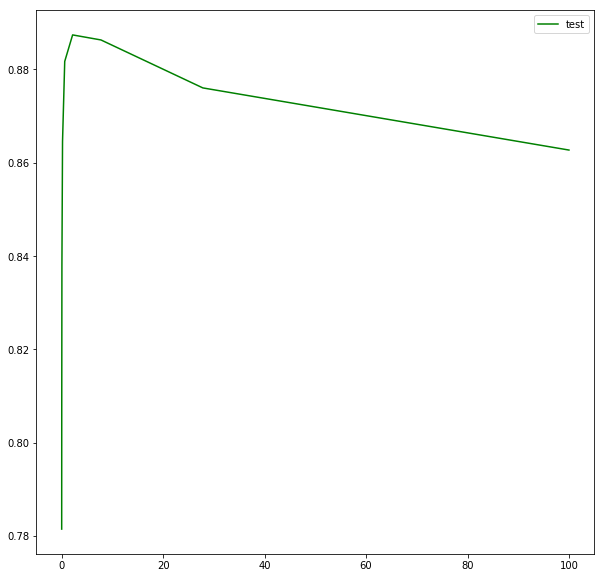

In [17]:
rcParams['figure.figsize'] = (10, 10)
plot_grid_scores(grid_lr, 'logisticregression__C')

### Стоит поискать параметр регуляризации в более узком диапазоне и не накладывать ограничения на max_features

In [18]:
%%time
pipeline = make_pipeline(TfidfVectorizer(ngram_range = (1, 2)), \
                        LogisticRegression(n_jobs = -1, random_state = 17))
params = {'logisticregression__C': np.logspace(1, 2, 5)}
grid_lr = GridSearchCV(pipeline, params, cv = 5, n_jobs = -1)

grid_lr.fit(text_train, y_train)

CPU times: user 51.5 s, sys: 13.8 s, total: 1min 5s
Wall time: 6min 29s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidfvectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 2),
                               

In [19]:
grid_lr.best_params_

{'logisticregression__C': 56.23413251903491}

In [20]:
grid_lr.best_score_

0.90628

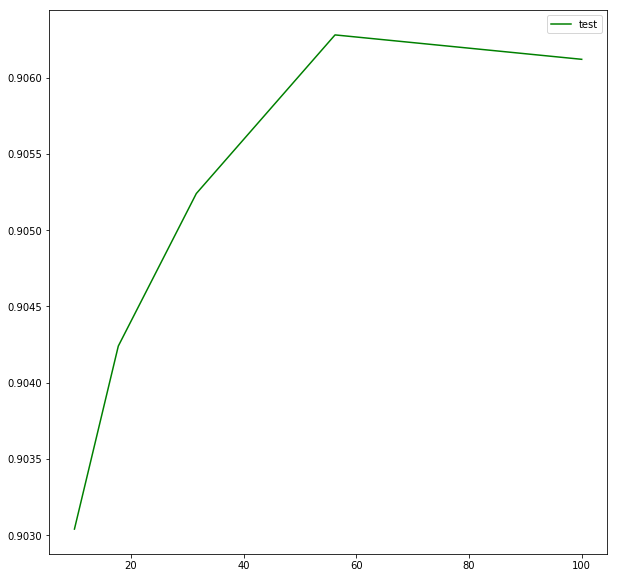

In [21]:
rcParams['figure.figsize'] = (10, 10)
plot_grid_scores(grid_lr, 'logisticregression__C')

In [22]:
%%time
cv = TfidfVectorizer(ngram_range=(1,2))
cv.fit(text_train)
X = cv.transform(text_train)
lr = LogisticRegression(C = 56, n_jobs = -1)
lr.fit(X, y_train)

CPU times: user 56.4 s, sys: 13.4 s, total: 1min 9s
Wall time: 42.7 s


LogisticRegression(C=56, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
X_test = cv.transform(text_test)
pred = lr.predict(X_test)
print("Test accuracy: %2.4f" % accuracy_score(pred, y_test))

Test accuracy: 0.9026


## Получили точность на тестовой выборке 0.9026

## Логистическая регрессия показывает хороший результат, но все же стоит попробовать модели другой архитектуры, а именно:
### 1) двухслойную нейронную сеть с нелинейностью ReLU  и слоем BatchNormalization 
### 2) 3-слойную нейронную сеть с нелинейностью ReLU  и двумя слоями BatchNormalization

In [24]:
cv = TfidfVectorizer(ngram_range=(1,2), max_features=7000)
cv.fit(text_train)
X_tr_transformed = cv.transform(text_train).toarray()
X_tr_transformed = np.hstack((X_tr_transformed, np.array(y_train).reshape(-1, 1)))

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

In [26]:
batch_size = 128

data_size = X_tr_transformed.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(X_tr_transformed, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(X_tr_transformed, batch_size=batch_size,
                                         sampler=val_sampler)

In [27]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, data in enumerate(train_loader):
            x = data[:, :7000].type(torch.FloatTensor)
            y = data[:, 7000].type(torch.LongTensor)
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        scheduler.step()
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):

    correct_samples = 0
    total_samples = 0
    for data in (loader):
        x = data[:, :7000].type(torch.FloatTensor)
        y = data[:, 7000].type(torch.LongTensor)
        prediction = model(x)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]
    accuracy = float(correct_samples) / total_samples

    return accuracy

In [28]:
nn_model = nn.Sequential(
            nn.Linear(X_tr_transformed.shape[1]-1, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2), 
         )
nn_model.type(torch.FloatTensor)
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [29]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 30, scheduler)

Average loss: 0.437789, Train accuracy: 0.807100, Val accuracy: 0.859400
Average loss: 0.254086, Train accuracy: 0.908600, Val accuracy: 0.872400
Average loss: 0.177928, Train accuracy: 0.942250, Val accuracy: 0.877000
Average loss: 0.124936, Train accuracy: 0.968850, Val accuracy: 0.878800
Average loss: 0.088897, Train accuracy: 0.984900, Val accuracy: 0.879200
Average loss: 0.062887, Train accuracy: 0.994200, Val accuracy: 0.879400
Average loss: 0.052751, Train accuracy: 0.996850, Val accuracy: 0.880000
Average loss: 0.044560, Train accuracy: 0.998050, Val accuracy: 0.879800
Average loss: 0.039344, Train accuracy: 0.999150, Val accuracy: 0.883200
Average loss: 0.034571, Train accuracy: 0.999300, Val accuracy: 0.882400
Average loss: 0.030674, Train accuracy: 0.999750, Val accuracy: 0.880200
Average loss: 0.028736, Train accuracy: 0.999750, Val accuracy: 0.880800
Average loss: 0.027478, Train accuracy: 0.999850, Val accuracy: 0.876600
Average loss: 0.026185, Train accuracy: 0.999850, V

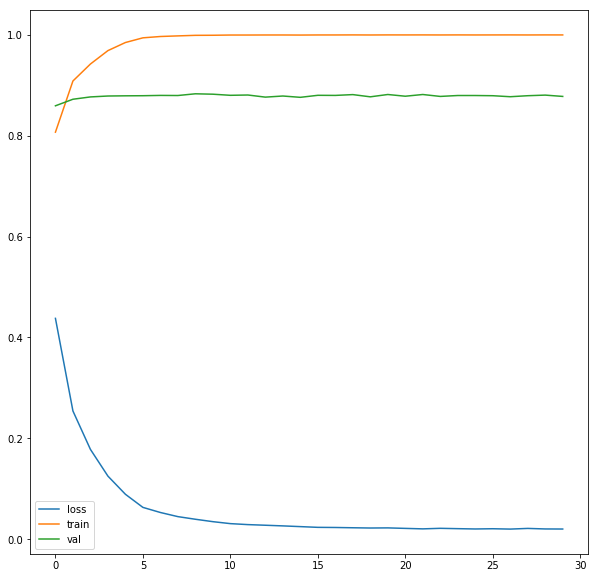

In [30]:
rcParams['figure.figsize'] = (10, 10)
plt.plot(loss_history, label = 'loss')
plt.plot(train_history, label = 'train')
plt.plot(val_history, label = 'val')
plt.legend();

In [31]:
nn_model = nn.Sequential(
            nn.Linear(X_tr_transformed.shape[1]-1, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace = True),
            nn.Linear(128, 2), 
         )
nn_model.type(torch.FloatTensor)
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=0.01, weight_decay=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [32]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 30, scheduler)

Average loss: 0.340416, Train accuracy: 0.847000, Val accuracy: 0.879800
Average loss: 0.110890, Train accuracy: 0.963950, Val accuracy: 0.864600
Average loss: 0.048515, Train accuracy: 0.988450, Val accuracy: 0.867800
Average loss: 0.027291, Train accuracy: 0.996100, Val accuracy: 0.868200
Average loss: 0.019041, Train accuracy: 0.998150, Val accuracy: 0.869400
Average loss: 0.012222, Train accuracy: 0.999800, Val accuracy: 0.871200
Average loss: 0.009271, Train accuracy: 1.000000, Val accuracy: 0.873200
Average loss: 0.009528, Train accuracy: 0.999950, Val accuracy: 0.870000
Average loss: 0.009189, Train accuracy: 1.000000, Val accuracy: 0.871400
Average loss: 0.009122, Train accuracy: 0.999950, Val accuracy: 0.870000
Average loss: 0.008801, Train accuracy: 0.999950, Val accuracy: 0.874400
Average loss: 0.009096, Train accuracy: 1.000000, Val accuracy: 0.872800
Average loss: 0.009041, Train accuracy: 1.000000, Val accuracy: 0.877000
Average loss: 0.009136, Train accuracy: 1.000000, V

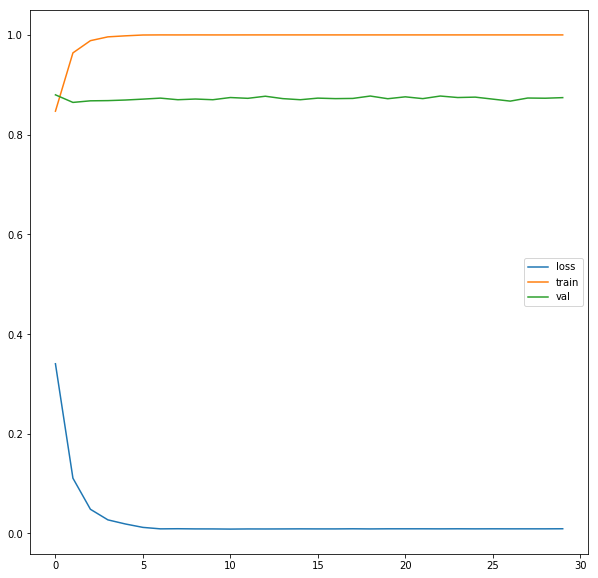

In [33]:
rcParams['figure.figsize'] = (10, 10)
plt.plot(loss_history, label = 'loss')
plt.plot(train_history, label = 'train')
plt.plot(val_history, label = 'val')
plt.legend();

In [34]:
X_test = cv.transform(text_test).toarray()
X_test = np.hstack((X_test, np.array(y_test).reshape(-1, 1)))
test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8709


### По результатам видно, что обе модели обладают достаточной мощностью, чтобы приблизить тренировочные данные практически безошибочно. Но при этом точность на валидации выходит на плато и результат получается чуть хуже, чем у логистической регрессии
### Данная архитектура нейронных сетей не подходит для нашей задачи, возможно, трансфер лернинг или нейронные сети другой архитектуры выступили бы лучше

## Теперь займемся прогнозированием рейтинга

In [35]:
X_tr, X_val, y_tr, y_val = train_test_split(text_train, rating_train, test_size = 0.2, shuffle = True)

In [36]:
cv = TfidfVectorizer(ngram_range=(1, 2))
cv.fit(X_tr)
X_tr = cv.transform(X_tr)

In [37]:
y_tr = list(map(lambda x: x if x <= 4 else x-2, y_tr))

In [38]:
linreg = LinearRegression(n_jobs=-1)
linreg.fit(X_tr, y_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [39]:
X_val = cv.transform(X_val)
pred = linreg.predict(X_val)

In [40]:
def redactor(x):
    if x > 8:
        return 10
    elif x < 1:
        return 1
    elif x < 4.5:
        return round(x)
    else:
        return round(x+2)

In [41]:
pred = list(map(redactor, pred))

In [42]:
pred = list(map(lambda x: round(x) if x < 4.5 else round(x+2), pred))

In [43]:
print("Test error: %2.4f" % np.sqrt(mean_squared_error(pred, y_val)))

Test error: 2.4143


### Теперь обучим на всей тренировочной выборке и посмотрим результат на тесте

In [44]:
cv = TfidfVectorizer(ngram_range=(1, 2))
cv.fit(text_train)
X_train = cv.transform(text_train)

In [45]:
y_train_rat = list(map(lambda x: x if x <= 4 else x-2, rating_train))

In [46]:
linreg = LinearRegression(n_jobs=-1)
linreg.fit(X_train, y_train_rat)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [47]:
X_test_rat = cv.transform(text_test)
pred = linreg.predict(X_test_rat)

In [48]:
pred = list(map(redactor, pred))

In [49]:
print("Test error: %2.4f" % np.sqrt(mean_squared_error(pred, rating_test)))

Test error: 1.9968


### Посмотрим, как наша модель работает на произвольных комментариях

In [50]:
def my_test(cv, lr, linreg, comment):
    comment_vec = cv.transform([comment])
    pred_class = lr.predict(comment_vec)
    if pred_class == 1:
        print('Positive')
    else:
        print('Negative')
    pred_rat = redactor(float(linreg.predict(comment_vec)))
    print('Rating:', round(pred_rat))

In [51]:
my_test(cv, lr, linreg, 'It was amazing! Wonderful film. I\'m enjoyed watching it. recommended to all friends and acquaintances')

Positive
Rating: 10


In [52]:
my_test(cv, lr, linreg, 'The film is positioned as a Comedy, but I didn\'t see anything funny there. for elementary school children, it may seem funny. lost an hour and a half of time just like that')

Negative
Rating: 3


In [53]:
#достаточно нейтральный комментарий, но с решением модели согласен
my_test(cv, lr, linreg, 'overall, it\'s a good movie, but I wouldn\'t watch it again.')

Positive
Rating: 8


In [54]:
my_test(cv, lr, linreg, 'Wonderful funny movie! The cast is right top. Olga Feigus is a beauty. Hun is awesome and funny. I\'d watch it a hundred more times. Plus the island itself is picturesque')

Positive
Rating: 9


In [55]:
my_test(cv, lr, linreg, 'The film is boring, no logic and the action is really slow, don’t recommend you to watch it')

Negative
Rating: 2


In [56]:
my_test(cv, lr, linreg, 'The movie is full of crazy moments, we had really much fun. Get your friends together to watch it!')

Positive
Rating: 8


In [57]:
my_test(cv, lr, linreg, 'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulence"-movies are better. In fact, every other movie in the world is better than this one.')

Negative
Rating: 1


## Получили 2 модели под нашу задачу. Теперь сохраним их

In [58]:
import pickle

In [59]:
pickl = {
    'vectorizer': cv,
    'logreg': lr,
    'linreg': linreg
}
pickle.dump( pickl, open( 'models' + ".p", "wb" ) )